<a id='home'></a>
### purpose

test IBE vs performance

### notes

when comparing RONA i still use the appropriate env distance (dependent upon selective envs for the seed) and not which envs are used to calculate RONA.

In [1]:
from pythonimports import *
from myfigs import draw_xy, save_pdf, scatter2d, histo_box

import MVP_summary_functions as mvp
import MVP_06_validate_RONA as mvp06
import MVP_10_train_lfmm2_offset as mvp10

import itertools as it
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import spearmanr
plt.rcParams.update({'font.family' : 'serif'})

lview, dview = get_client(cluster_id='1699628799-7ld4', profile='lotterhos')

t0 = dt.now()  # notebook timer

figdir = makedir('/home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	November 10, 2023 - 12:22:12 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 782ee79eada654ce337935bf61a0984cd76dd9cf  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Oct 4 14:13:12 2023 -0400
#########################################################



# get metadata

In [2]:
# load metadata
params = mvp.read_params_file()

params['num_traits'] = params.level.apply(lambda level: '1-trait' if '1-trait' in level else '2-trait')

summary = mvp.get_summary_data()

params['final_LA'] = params.index.map(summary.final_LA)

trait_dict = params.groupby('num_traits')['seed'].apply(list).to_dict()

params['dummy_slevel'] = params.slevel
params.dummy_slevel[params.dummy_slevel.isnull()] = '1-trait'

params.head()

100%|███████████████| 2250/2250 [00:02<00:00, 837.98it/s]
/tmp/ipykernel_265724/3913630903.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params.dummy_slevel[params.dummy_slevel.isnull()] = '1-trait'


level  reps  \
1231094  highly-polygenic_1-trait__Est-Clines_N-cline-c...     1   
1231095  highly-polygenic_1-trait__Est-Clines_N-cline-N...     1   
1231096  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231097  highly-polygenic_1-trait__Est-Clines_N-equal_m...     1   
1231098  highly-polygenic_1-trait__Est-Clines_N-variabl...     1   

                             arch  \
1231094  highly-polygenic_1-trait   
1231095  highly-polygenic_1-trait   
1231096  highly-polygenic_1-trait   
1231097  highly-polygenic_1-trait   
1231098  highly-polygenic_1-trait   

                                           demog_name  \
1231094  Est-Clines_N-cline-center-to-edge_m-constant   
1231095          Est-Clines_N-cline-N-to-S_m-constant   
1231096                   Est-Clines_N-equal_m_breaks   
1231097                 Est-Clines_N-equal_m-constant   
1231098              Est-Clines_N-variable_m-variable   

                           demog_level_sub demog_level  MIG_x  MIG_y  xcline  \
1231094  N-cline-center-to-edge_m-constant  Est-Clines   0.49   0.07  linear   
1231095          N-cline-N-to-S_m-constant  Est-Clines   0.49   0.07  linear   
1231096                   N-equal_m_breaks  Est-Clines   0.49   0.07  linear   
1231097                 N-equal_m-constant  Est-Clines   0.49   0.07  linear   
1231098              N-variable_m-variable  Est-Clines   0.49   0.07  linear   

         ycline    demog  METAPOP_SIDE_x  METAPOP_SIDE_y  Nequal  isVariableM  \
1231094  linear  Estuary              10              10       4            0   
1231095  linear  Estuary              10              10       2            0   
1231096  linear  Estuary              10              10       0            0   
1231097  linear  Estuary              10              10       0            0   
1231098  linear  Estuary              10              10       3            1   

         MIG_breaks arch_level_sub        arch_level       MU_base  \
1231094           0        1-trait  highly-polygenic  1.000000e-07   
1231095           0        1-trait  highly-polygenic  1.000000e-07   
1231096           1        1-trait  highly-polygenic  1.000000e-07   
1231097           0        1-trait  highly-polygenic  1.000000e-07   
1231098           0        1-trait  highly-polygenic  1.000000e-07   

         MU_QTL_proportion  SIGMA_QTN_1  SIGMA_QTN_2  SIGMA_K_1  SIGMA_K_2  \
1231094               0.25        0.002        0.002        0.5        0.5   
1231095               0.25        0.002        0.002        0.5        0.5   
1231096               0.25        0.002        0.002        0.5        0.5   
1231097               0.25        0.002        0.002        0.5        0.5   
1231098               0.25        0.002        0.002        0.5        0.5   

         N_traits  ispleiotropy     seed  final_LA            glevel   plevel  \
1231094         1             0  1231094  0.500854  highly-polygenic  1-trait   
1231095         1             0  1231095  0.505075  highly-polygenic  1-trait   
1231096         1             0  1231096  0.499265  highly-polygenic  1-trait   
1231097         1             0  1231097  0.499365  highly-polygenic  1-trait   
1231098         1             0  1231098  0.501054  highly-polygenic  1-trait   

                 pleio slevel   landscape                 popsize   migration  \
1231094  no pleiotropy    NaN  Est-Clines  N-cline-center-to-edge  m-constant   
1231095  no pleiotropy    NaN  Est-Clines          N-cline-N-to-S  m-constant   
1231096  no pleiotropy    NaN  Est-Clines                 N-equal    m-breaks   
1231097  no pleiotropy    NaN  Est-Clines                 N-equal  m-constant   
1231098  no pleiotropy    NaN  Est-Clines              N-variable  m-variable   

           landscape-slevel num_traits dummy_slevel  
1231094  Est-Clines_1-trait    1-trait      1-trait  
1231095  Est-Clines_1-trait    1-trait      1-trait  
1231096  Est-Clines_1-trait    1-trait      1-trait  
1231097  Est-Clines_1-trait   

In [3]:
# make local adaptation bins - copied to 02_analysis/02_main_questions/02_Q1_performance_vs_local-adaptation_figures.ipynb
num_bins = 3

color_map = sns.color_palette("ch:s=-.2, r=.6", n_colors=num_bins)[:-1]

summary['final_LA_bin'] = np.nan
labels = []
for x in np.linspace(summary.final_LA.min(), summary.final_LA.max(), num_bins)[1:]:
    current_bin = round(x, 2)

    if len(labels) == 0:
        label = f'%s < LA ≤ {current_bin}' % summary.final_LA.round(2).min()
    else:
        label = f'{last_bin} < LA ≤ {current_bin}'
        
    last_bin = current_bin
    
    print(label)
    
    summary.loc[(summary.final_LA <= x) & (summary.final_LA_bin.isnull()), 'final_LA_bin'] = label
    
    mvp.boxplot_kwargs['palette'][label] = color_map[len(labels)]
    
    labels.append(label)
    
mvp.hue_order['final_LA_bin'] = labels  #[::-1]

# add metadata
for label in labels:
    mvp.factor_names[label] = label
    
# add metadata
mvp.factor_names['final_LA_bin'] = 'Degree of Local Adaptation'

0.25 < LA ≤ 0.42
0.42 < LA ≤ 0.58


In [4]:
# get one seed from each landscape (climate is same for the same landscape) for each number of adaptive traits
landscape_trait_seeds = params.groupby(['demog_level', 'num_traits'])['seed'].apply(list).to_dict()

landscape_trait_seed = {}
for (landscape, num_traits), seed_list in landscape_trait_seeds.items():
    print(f'{landscape}_{num_traits}', seed_list[0])
    landscape_trait_seed[f'{landscape}_{num_traits}'] = seed_list[0]

Est-Clines_1-trait 1231094
Est-Clines_2-trait 1231109
SS-Clines_1-trait 1231099
SS-Clines_2-trait 1231114
SS-Mtn_1-trait 1231104
SS-Mtn_2-trait 1231119


# Calculate env distance for common gardens

only need to do this once per landscape

In [5]:
def calc_climate_distances(seed, num_traits):
    """Calculate Euclidean climate distance between pops on a landscape."""
    subset, locations, envdata = mvp06.get_pop_data(mvp.slimdir, seed)
    
    if num_traits == '1-trait':
        print(f'\tremoving sal_opt from {num_traits} calculation')
        envdata.pop('sal_opt')
    
    # get pairwise distances
    dist = defaultdict(dict)
    for pop_i, pop_j in it.combinations(envdata.index, r=2):
        dist[pop_i][pop_j] = math.dist(envdata.loc[pop_i], envdata.loc[pop_j])  # euclidean distance
        dist[pop_j][pop_i] = dist[pop_i][pop_j]
        
        # diagonal (overwriting in subsequent step of loop is fine)
        dist[pop_i][pop_i] = 0
        dist[pop_j][pop_j] = 0
        
    dist_df = pd.DataFrame(dist)
    
    dist_df = dist_df.loc[sorted(dist_df.index), sorted(dist_df.columns)]    
    
    return dist_df

In [6]:
climate_distances = {}
for landscape_ntraits, seed in landscape_trait_seed.items():
    print(f'\n{landscape_ntraits}')
    climate_distances[landscape_ntraits] = calc_climate_distances(seed, landscape_ntraits.split("_")[1])


Est-Clines_1-trait

Reading in info for subsampled individuals ...
	removing sal_opt from 1-trait calculation

Est-Clines_2-trait

Reading in info for subsampled individuals ...

SS-Clines_1-trait

Reading in info for subsampled individuals ...
	removing sal_opt from 1-trait calculation

SS-Clines_2-trait

Reading in info for subsampled individuals ...

SS-Mtn_1-trait

Reading in info for subsampled individuals ...
	removing sal_opt from 1-trait calculation

SS-Mtn_2-trait

Reading in info for subsampled individuals ...


# retrieve FST estimates

fst seffs are checked at end of notebook

In [7]:
def get_fst(repdir):
    from pythonimports import fs
    import pandas as pd
    from collections import defaultdict
    from os import path as op
    
    fst_dir = f'{repdir}/fst'
        
    files = fs(fst_dir, endswith='.txt')
    
    assert len(files) == 675  #  225 seeds * 3 marker sets
    
    fst_dfs = defaultdict(dict)
    for f in files:
        seed, marker_set, *_ = op.basename(f).split("_")
        df = pd.read_table(f, index_col=0).fillna(0)     # DEBUG!
        df.columns = df.columns.astype(int)
        fst_dfs[seed][marker_set] = df

    return fst_dfs

In [8]:
# retrieve FST in parallel
jobs = []
for repdir in mvp.repdirs:
    jobs.append(
        lview.apply_async(
            get_fst, repdir
        )
    )
    
watch_async(jobs)

fst_dfs = {}
for j in jobs:
    fst_dfs.update(j.r)
    
assert len(fst_dfs) == 2250  # 225 seeds * 10 reps


Watching 10 jobs ...


100%|███████████████| 10/10 [00:09<00:00,  1.04it/s]


In [9]:
# assert 3 marker sets per seed
for seed in fst_dfs:
    assert len(fst_dfs[seed]) == 3

# calculate IBE (correlation between FST and climate dist)

In [10]:
params.demog_level.unique()

array(['Est-Clines', 'SS-Clines', 'SS-Mtn'], dtype=object)

In [11]:
dist_corrs = defaultdict(dict)
for (seed, marker_set), fst_df in unwrap_dictionary(fst_dfs, progress_bar=True):
    # get correct climate distance
    landscape = params.loc[seed, 'demog_level']
    num_traits = params.loc[seed, 'num_traits']
    cdist = climate_distances[f'{landscape}_{num_traits}']
    
    # calc correlation
    rho = spearmanr(lower_tri(cdist), lower_tri(fst_df)).correlation
    
    dist_corrs[seed][marker_set] = rho

100%|███████████████| 2250/2250 [00:10<00:00, 217.70it/s]


In [12]:
corr_df = pd.DataFrame(dist_corrs)

corr_df

1231094   1231095   1231096   1231097   1231098   1231099  \
adaptive  0.928419  0.724388  0.952396  0.963189  0.838841  0.654849   
all       0.907638  0.732075  0.971627  0.967951  0.839331  0.518723   
neutral   0.904934  0.737878  0.968654  0.962997  0.830187  0.486564   

           1231100   1231101   1231102   1231103   1231104   1231105  \
adaptive  0.615601  0.842283  0.798687  0.549209  0.640068  0.538729   
all       0.514924  0.789537  0.627899  0.419513  0.518323  0.495138   
neutral   0.504292  0.782030  0.572302  0.385274  0.485665  0.477999   

           1231106   1231107   1231108   1231109   1231110   1231111  \
adaptive  0.879719  0.763682  0.609248  0.673321  0.549446  0.654553   
all       0.816955  0.623024  0.510167  0.645403  0.509850  0.629566   
neutral   0.781068  0.579171  0.474933  0.638132  0.502415  0.620449   

           1231112   1231113   1231114   1231115   1231116   1231117  \
adaptive  0.654239  0.636920  0.827337  0.682419  0.884929  0.923793   
all       0.624460  0.611237  0.757919  0.556366  0.865934  0.883421   
neutral   0.619119  0.601861  0.728521  0.522216  0.839371  0.844526   

           1231118   1231119   1231120   1231121   1231122   1231123  \
adaptive  0.766868  0.547443  0.506620  0.703294  0.650147  0.571034   
all       0.689322  0.476378  0.402215  0.588422  0.552980  0.419642   
neutral   0.649046  0.467906  0.376023  0.549490  0.506820  0.372617   

           1231124   1231125   1231126   1231127   1231128   1231129  \
adaptive  0.640937  0.522651  0.630672  0.634559  0.522936  0.802686   
all       0.628611  0.489988  0.627977  0.609973  0.533932  0.741761   
neutral   0.615475  0.487079  0.624882  0.607240  0.545811  0.718026   

           1231130   1231131   1231132   1231133   1231134   1231135  \
adaptive  0.639815  0.916125  0.886783  0.744514  0.528371  0.472318   
all       0.544276  0.867972  0.884026  0.725073  0.465062  0.392804   
neutral   0.520098  0.836589  0.853657  0.714286  0.458001  0.376530   

           1231136   1231137   1231138   1231139   1231140   1231141  \
adaptive  0.672279  0.648270  0.563538  0.639685  0.521555  0.647347   
all       0.568175  0.533410  0.451377  0.634587  0.490216  0.629884   
neutral   0.538566  0.506026  0.413001  0.629506  0.488193  0.621413   

           1231142   1231143  ...   1233294   1233295   1233296   1233297  \
adaptive  0.601497  0.495821  ...  0.557333  0.744915  0.812435  0.730098   
all       0.606230  0.488587  ...  0.462543  0.397653  0.578748  0.544538   
neutral   0.607232  0.501181  ...  0.458198  0.372380  0.544369  0.503600   

           1233298   1233299   1233300   1233301   1233302   1233303  \
adaptive  0.628262  0.793123  0.776309  0.620147  0.753349  0.750726   
all       0.361456  0.642941  0.502033  0.613531  0.612284  0.613833   
neutral   0.348904  0.627978  0.505495  0.618009  0.604790  0.606859   

           1233304   1233305   1233306   1233307   1233308   1233309  \
adaptive  0.851055  0.854458  0.790604  0.793747  0.808924  0.843183   
all       0.741463  0.559489  0.858922  0.888533  0.538282  0.474849   
neutral   0.710334  0.531048  0.830278  0.858375  0.508207  0.453787   

           1233310   1233311   1233312   1233313   1233314   1233315  \
adaptive  0.680873  0.591253  0.760153  0.605637  0.731583  0.740347   
all       0.385156  0.561912  0.526593  0.376479  0.626589  0.514194   
neutral   0.371917  0.534483  0.488510  0.364542  0.620948  0.508648   

           1233316   1233317   1233318   1233319   1233320   1233321  \
adaptive  0.748592  0.571066  0.666361  0.768465  0.729823  0.799545   
all       0.632000  0.607229  0.609315  0.771560  0.578149  0.867956   
neutral   0.621342  0.606095  0.593498  0.748953  0.549528  0.829302   

           1233322   1233323   1233324   1233325   1233326   1233327  \
adaptive  0.756074  0.765191  0.696381  0.717424  0.662306  0.739240   
all       0.903309  0.724769  0.475436  0.419669  0.590976  0.586512   
neutral   0.874863

In [13]:
# annotate dataframe with metadata
corr_anno = corr_df.T.reset_index().melt(id_vars='index')
for param in mvp.hue_order.keys():
    if param in ['noncausal_env', 'marker_set', 'program', 'demography', 'final_LA_bin']:
        continue
        
    corr_anno[param] = corr_anno['index'].map(params[param])

corr_anno['demography'] = corr_anno['popsize'] + '_' + corr_anno['migration']
corr_anno['final_LA_bin'] = corr_anno['index'].map(summary['final_LA_bin'])
corr_anno['final_LA'] = corr_anno['index'].map(params['final_LA'])
    
corr_anno.head()

index  variable     value   landscape            glevel          pleio  \
0  1231094  adaptive  0.928419  Est-Clines  highly-polygenic  no pleiotropy   
1  1231095  adaptive  0.724388  Est-Clines  highly-polygenic  no pleiotropy   
2  1231096  adaptive  0.952396  Est-Clines  highly-polygenic  no pleiotropy   
3  1231097  adaptive  0.963189  Est-Clines  highly-polygenic  no pleiotropy   
4  1231098  adaptive  0.838841  Est-Clines  highly-polygenic  no pleiotropy   

  slevel                 popsize   migration  \
0    NaN  N-cline-center-to-edge  m-constant   
1    NaN          N-cline-N-to-S  m-constant   
2    NaN                 N-equal    m-breaks   
3    NaN                 N-equal  m-constant   
4    NaN              N-variable  m-variable   

                          demography      final_LA_bin  final_LA  
0  N-cline-center-to-edge_m-constant  0.42 < LA ≤ 0.58  0.500854  
1          N-cline-N-to-S_m-constant  0.42 < LA ≤ 0.58  0.505075  
2                   N-equal_m-breaks  0.42 < LA ≤ 0.58  0.499265  
3                 N-equal_m-constant  0.42 < LA ≤ 0.58  0.499365  
4              N-variable_m-variable  0.42 < LA ≤ 0.58  0.501054

### save

In [14]:
# save in tmp
corr_df.to_csv(f'{figdir}/ibe_corrs.txt', sep='\t', index=True, header=True)

In [15]:
corr_anno.to_csv(f'{figdir}/ibe_corrs_anno.txt', sep='\t', header=True, index=False)

In [16]:
# corr_df = pd.read_table(f'{figdir}/ibe_corrs.txt', index_col=0)
# display(corr_df.head())

# corr_anno = pd.read_table(f'{figdir}/ibe_corrs_anno.txt')
# corr_anno.head()

# get performance data

get median score across gardens for a given permutation

In [17]:
# get all data
all_data = mvp.combine_level_dicts(
    use_bcs_data=False,
    keep_nuisance=False,
#         repdirs=['/home/b.lind/offsets/run_20220919_0-225']
    )

# apply median performance to each marker set
marker_data = {}
for marker_set in mvp.hue_order['marker_set']:
    marker_data[marker_set] = mvp.subset_data_scores(
        all_data.copy(),
        apply_median=True,
        marker_set=marker_set
    )

filtering criteria:
	use_bcs_data = False
	performance = garden_performance
	num_traits = None
	ntraits = None
	marker_set = None
	remove_structcrxn = False
	keep_nuisance = False
	remove_rda_outliers = True


reading reps: 100%|███████████████| 10/10 [00:25<00:00,  2.50s/it]


0-225
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


225-450
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


450-675
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


675-900
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


900-1125
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1125-1350
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1350-1575
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1575-1800
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


1800-2025
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


2025-2250
	 RONA num seeds =  225
	 lfmm2 num seeds =  22

In [18]:
# RONA sal_opt only has 180 because ther are only 180 2-trait levels; sal_opt is not adaptive in 1-trait seeds
for marker_set in keys(marker_data):
    for program in marker_data[marker_set]:
        print(marker_set, program, marker_data[marker_set][program].__len__())
    print(' ')

adaptive RONA-sal_opt 1800
adaptive RONA-temp_opt 2250
adaptive lfmm2 2250
adaptive GF 2250
adaptive rda-nocorr 2250
adaptive rda-structcorr 2250
 
all RONA-sal_opt 1800
all RONA-temp_opt 2250
all lfmm2 2250
all GF 2250
all rda-nocorr 2250
all rda-structcorr 2250
 
neutral RONA-sal_opt 1800
neutral RONA-temp_opt 2250
neutral lfmm2 2250
neutral GF 2250
neutral rda-nocorr 2250
neutral rda-structcorr 2250
 


# make figures

### levels of IBE among marker sets

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_IBE_boxplot.pdf


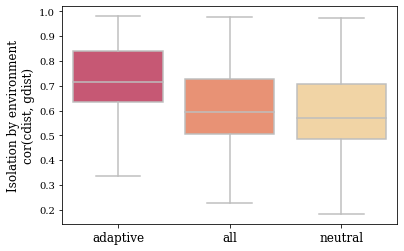

In [19]:
# across all datasets
g = sns.boxplot(
    data=corr_df.T,
    **mvp.boxplot_kwargs
)

g.axes.set_ylabel("Isolation by environment\ncor(cdist, gdist)", fontsize=12)

mvp.update_ticklabels(g.axes, fontsize=12)

save_pdf(f'{figdir}/marker_set_IBE_boxplot.pdf')

1913 2250


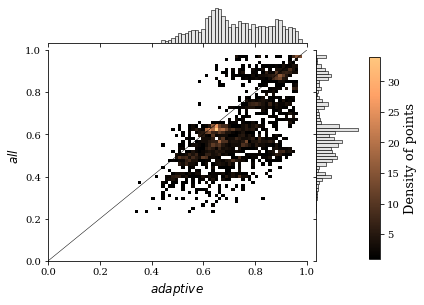

1986 2250


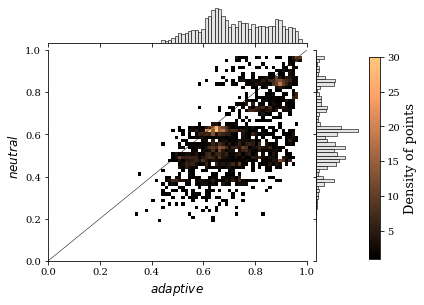

2109 2250


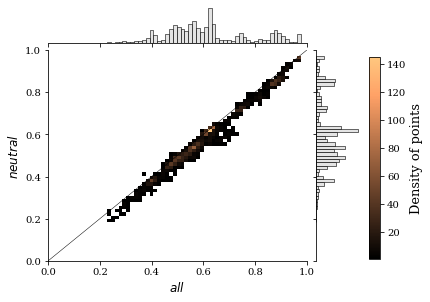

In [57]:
# compare IBE between marker sets for each dataset
for marker_set_i, marker_set_j in it.combinations(mvp.hue_order['marker_set'], r=2):
    
    print(
        sum(corr_df.loc[marker_set_i] > corr_df.loc[marker_set_j]), ncol(corr_df)
    )
    
    ax = scatter2d(
        x=corr_df.loc[marker_set_i],
        y=corr_df.loc[marker_set_j],
        marginal_kws={'color' : 'gainsboro'},
        cmap='copper',
        xlab=f'$\it{marker_set_i}$',
        ylab=f'$\it{marker_set_j}$',
        normalization=mcolors.Normalize,
        snsbins=50,
        bins=50
    )
    
    ax.ax_joint.set_ylim(0, 1)
    
    ax.ax_joint.set_title(None)
    
    draw_xy(ax.ax_joint)

    plt.show()

In [90]:
?plt.subplots

adaptive all
fraction.min() = 0.3523470280440543
adaptive neutral
fraction.min() = 0.2771075363352749
all neutral
fraction.min() = 0.7481209930463215


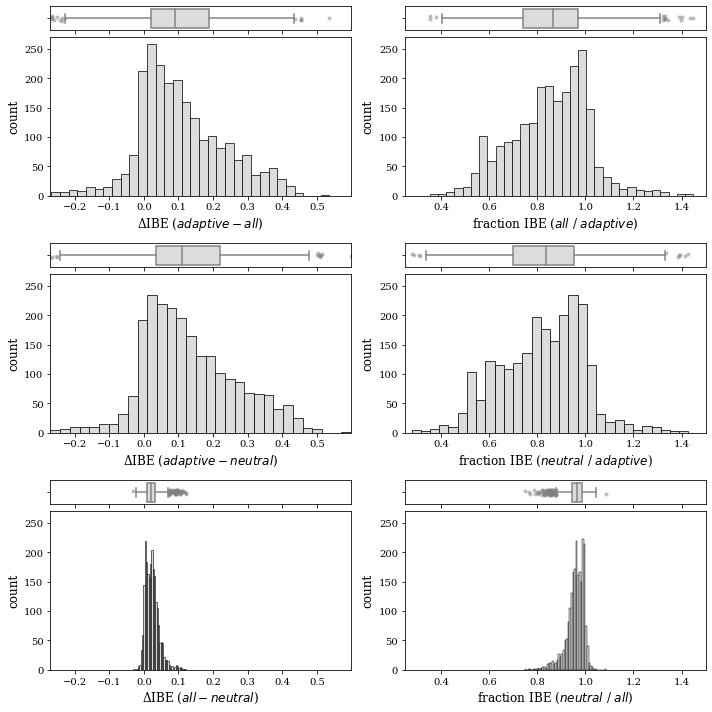

In [96]:
# distribution of differences in IBE within datasets
xmin = math.inf
xmax = -math.inf
diffs = {}
for marker_set_i, marker_set_j in it.combinations(mvp.hue_order['marker_set'], r=2):
    diff = corr_df.loc[marker_set_i] - corr_df.loc[marker_set_j]
    xmin = diff.min() if diff.min() < xmin else xmin
    xmax = diff.max() if diff.max() > xmax else xmax
    diffs[f'{marker_set_i} {marker_set_j}'] = diff

    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10)); i=0
for marker_set_i, marker_set_j in it.combinations(mvp.hue_order['marker_set'], r=2):
    print(ColorText(f'{marker_set_i} {marker_set_j}').bold().custom('blue'))
    
    (ax1, ax2) = axes[i]
    # count histogram
    ax_box, ax_hist = histo_box(
        corr_df.loc[marker_set_i] - corr_df.loc[marker_set_j],
        jit = 0.1, histplot_kws={'facecolor' : 'gainsboro'}, boxplot_kws={'color' : 'gainsboro'},
        xlab=f'ΔIBE ($\it{marker_set_i} - {marker_set_j}$)', ylab='count',
        xlim=(xmin, xmax), ylim=(0, 270),
        ax=ax1
    )

#     plt.show()
    
    # perc histogram
    fraction = corr_df.loc[marker_set_j] / corr_df.loc[marker_set_i]
    ax_box, ax_hist = histo_box(
        fraction,
        jit = 0.1, histplot_kws={'facecolor' : 'gainsboro'}, boxplot_kws={'color' : 'gainsboro'},
        xlab=f'fraction IBE ($\it{marker_set_j}$ / $\it{marker_set_i}$)', ylab='count',
        ax=ax2, ylim=(0, 270), xlim=(0.25, 1.5)
#         xlim=(xmin, xmax)
    )
    
    print(f'{fraction.min() = }')
    
#     plt.show()
    
    i += 1

plt.tight_layout()
plt.show()

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_landscape.pdf


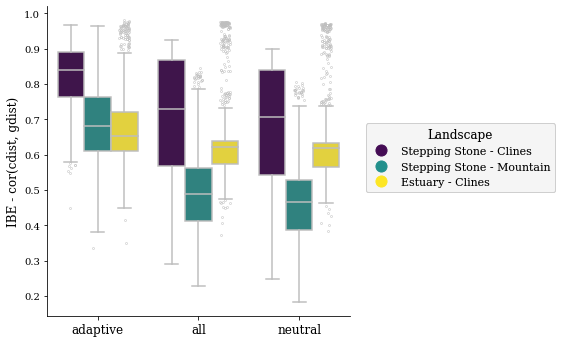

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_glevel.pdf


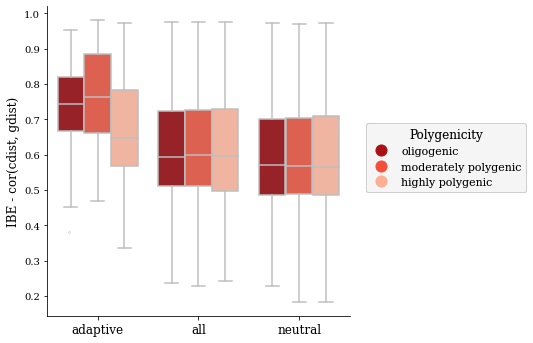

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_pleio.pdf


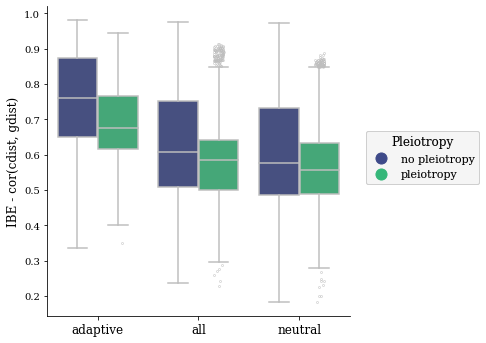

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_slevel.pdf


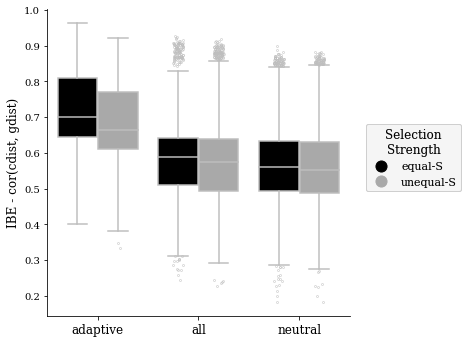

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_popsize.pdf


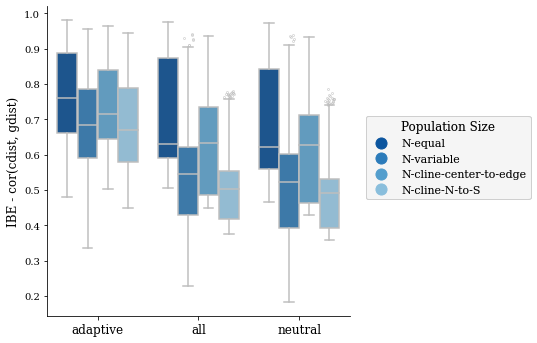

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_migration.pdf


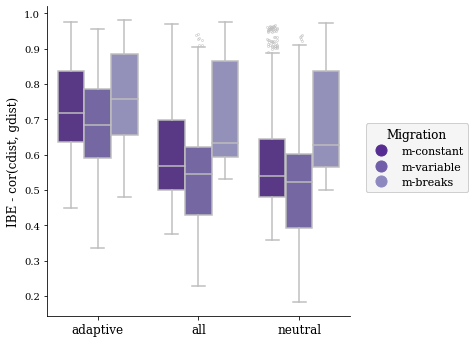

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_demography.pdf


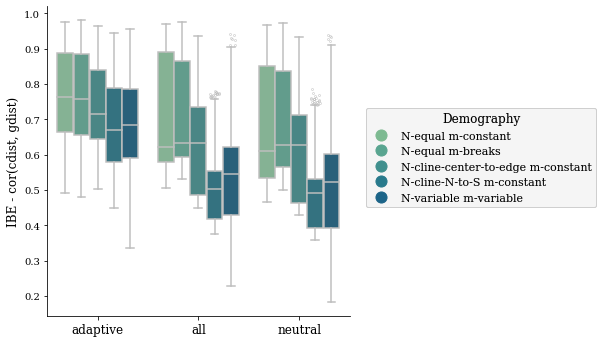

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/marker_set_by_IBE_by_final_LA_bin.pdf


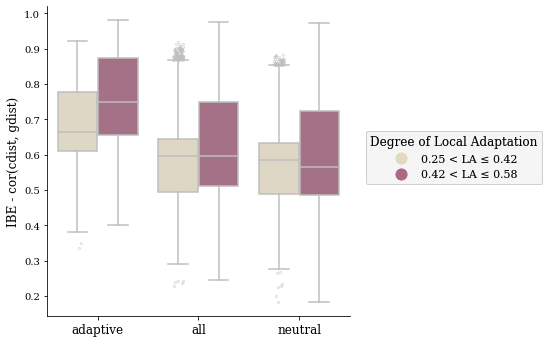

In [20]:
for param in corr_anno.columns[3:-1]:
    g = sns.catplot(
        data=corr_anno,
        y='value',
        x='variable',
        hue=param,
        hue_order=mvp.hue_order[param],
        **mvp.boxplot_kwargs,
        kind='box',
        legend=False
    )
    
    mvp.add_legend(g.figure, color_by=param, loc='center left', bbox_to_anchor=(1, 0.55))
    
    mvp.jitter_fliers(g)
    
    g.ax.set_ylabel('IBE - cor(cdist, gdist)', fontsize=12)
    
    g.ax.set_xlabel(None)
    
    mvp.update_ticklabels(g.ax, fontsize=12)
    
    save_pdf(f'{figdir}/marker_set_by_IBE_by_{param}.pdf')
    
    plt.show()

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/degree_of_la_by_landscape.pdf


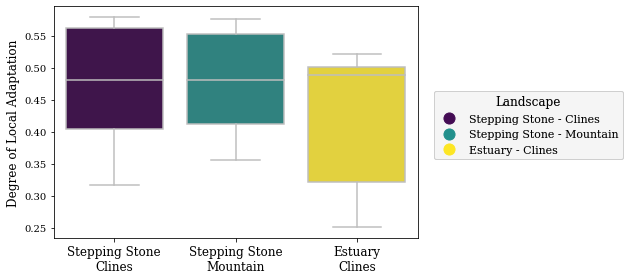

In [21]:
# just a plot to compare with IBE across landscapes in the cell immediately above this one
g = sns.boxplot(
    data=params,
    x='landscape',
    order=mvp.hue_order['landscape'],
    y='final_LA',
    **mvp.boxplot_kwargs
)

g.set_ylabel("Degree of Local Adaptation", fontsize=12)
g.set_xlabel(None)

mvp.update_ticklabels(g, replace=(' - ', '\n'), fontsize=12)
mvp.add_legend(g.figure, color_by='landscape', loc='center left', bbox_to_anchor=(1, 0.55))

plt.tight_layout()

save_pdf(f'{figdir}/degree_of_la_by_landscape.pdf')

plt.show()

### IBE vs local adaptation by method

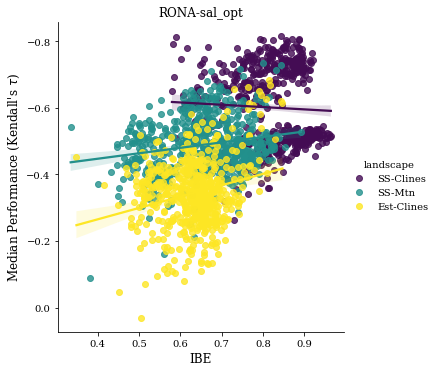

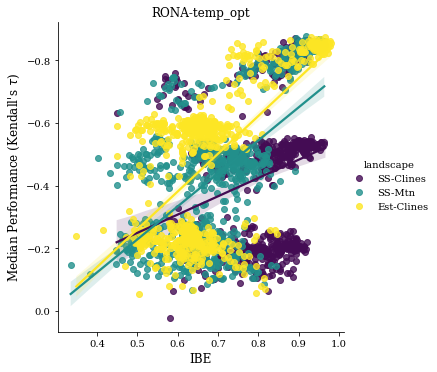

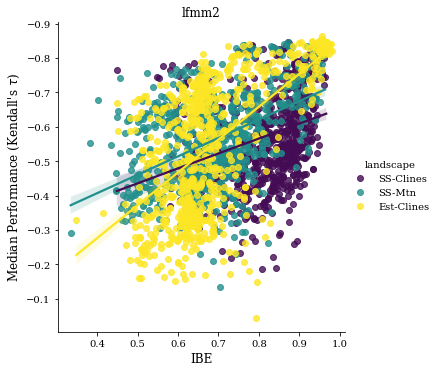

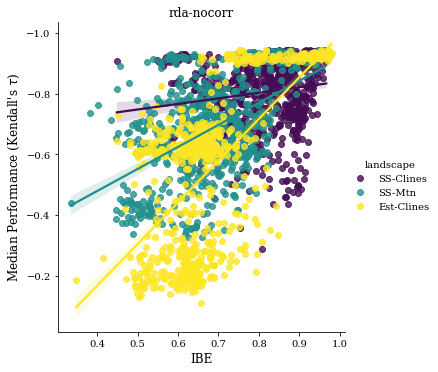

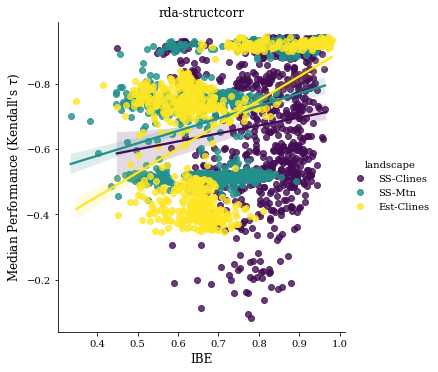

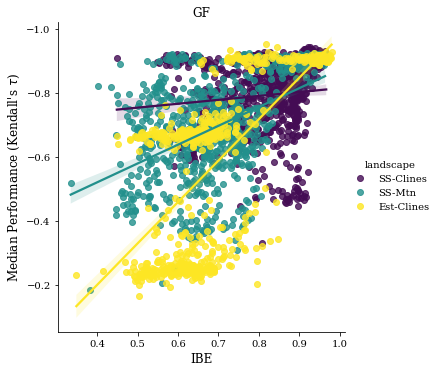

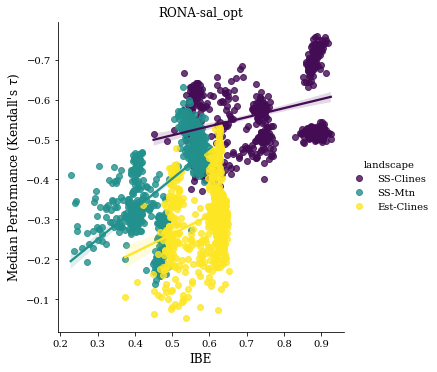

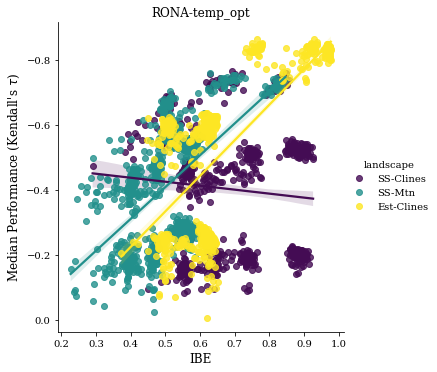

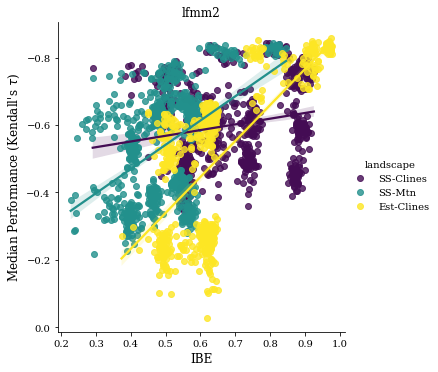

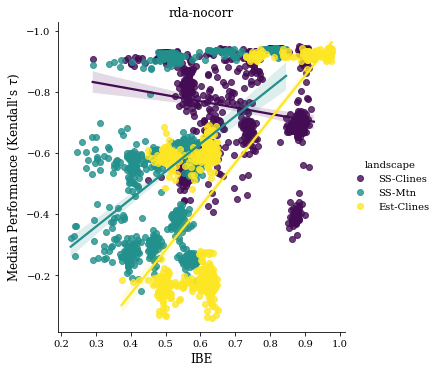

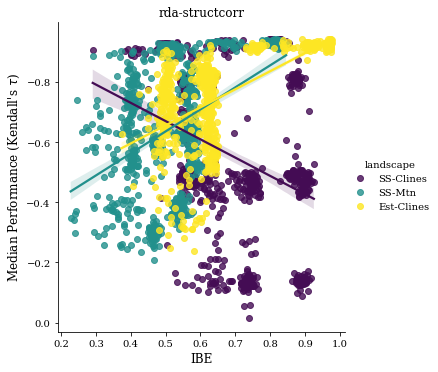

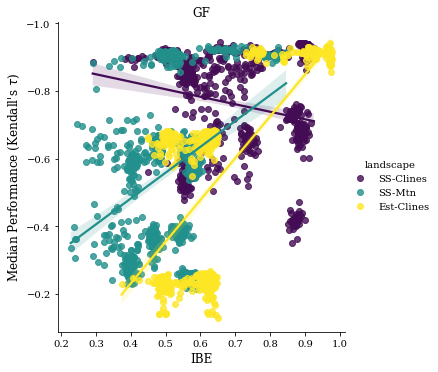

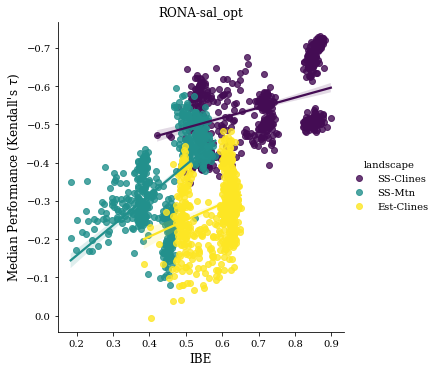

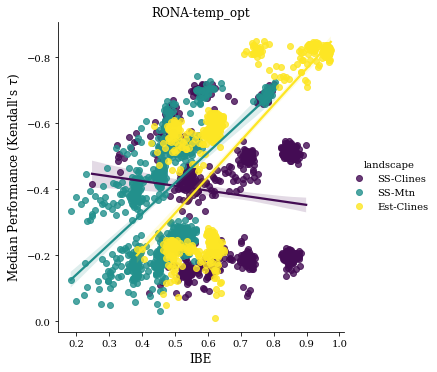

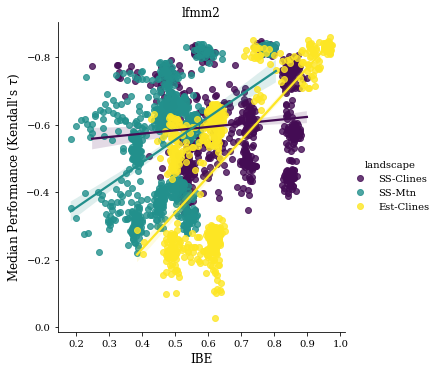

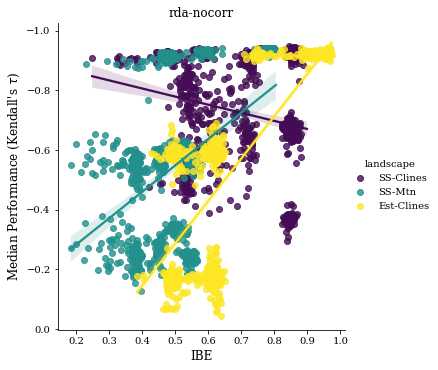

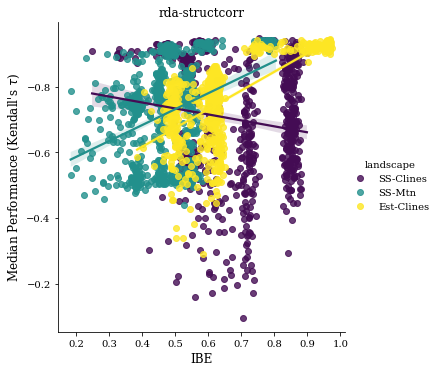

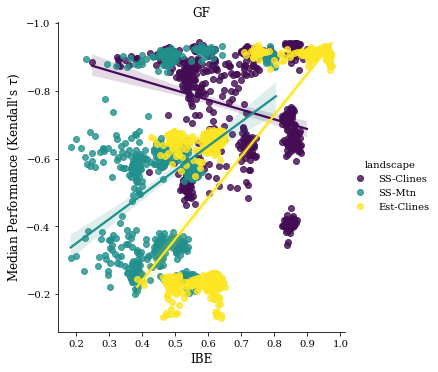

In [22]:
for marker_set in mvp.hue_order['marker_set']:
    df = corr_anno[corr_anno.variable == marker_set].copy()
    
    for program in mvp.hue_order['program']:
        df[program] = df['index'].map(marker_data[marker_set][program])
        g = sns.lmplot(
            data=df,
            y=program,
            x='value',
            hue='landscape',
            hue_order=mvp.hue_order['landscape'],
            palette=mvp.boxplot_kwargs['palette']
        )

        g.ax.invert_yaxis()
        g.ax.set_ylabel("Median Performance (Kendall's $\\tau$)", fontsize=12)
        g.ax.set_xlabel('IBE', fontsize=12)
        g.ax.set_title(program)

        plt.show()

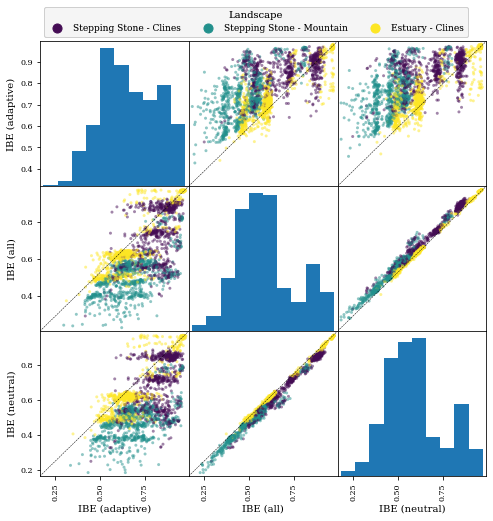

In [23]:
def compare_IBE(hue='landscape'):
    tcorr = corr_df.T.copy()
    
    if hue == 'landscape':
        colors = tcorr.index.map(params[hue]).map(mvp.boxplot_kwargs['palette'])
    else:
        colors = tcorr.index.map(summary[hue]).map(mvp.boxplot_kwargs['palette'])

    fig = pd.plotting.scatter_matrix(tcorr,
                                     figsize=(8, 8),
                                     color=colors)

    __ = fig[0][0].set_yticklabels([round(float(x.get_text()), 2) for x in fig[0][0].get_yticklabels()])

    for row, axes in enumerate(fig):
        for col, ax in enumerate(axes):
            if row != col:
                draw_xy(ax, linestyle='--')

            if col == 0:
                label = ax.get_ylabel()
                ax.set_ylabel(f'IBE ({label})')

            if row == 2:
                label = ax.get_xlabel()
                ax.set_xlabel(f'IBE ({label})')
    return fig

fig = compare_IBE(hue='landscape')
mvp.add_legend(fig[0][0].figure, color_by='landscape',
               fontsize=9, ncol='auto', loc='lower center', bbox_to_anchor=(0.5, 0.88))

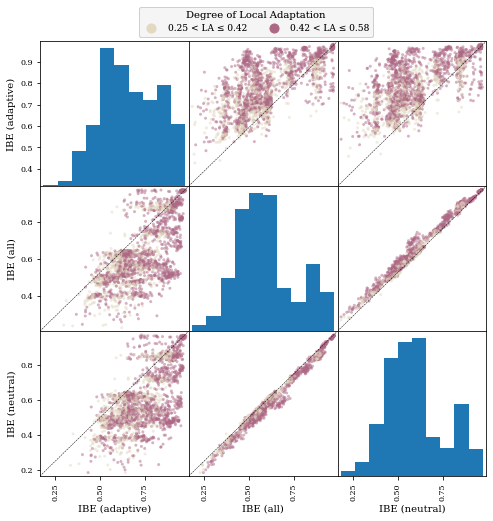

In [24]:
out = compare_IBE(hue='final_LA_bin')
mvp.add_legend(out[0][0].figure, fontsize=9, color_by='final_LA_bin', ncol='auto', loc='lower center', bbox_to_anchor=(0.5, 0.88))

### is performance v final_LA stronger than performance vs cor(fdist, cdist)?

In [25]:
# make seaborn-compatable dataframe
ibe_anno = corr_df.T.copy()
for param in ['landscape', 'slevel']:
    ibe_anno[param] = ibe_anno.index.map(params[param])
    
ibe_anno['final_LA'] = ibe_anno.index.map(summary.final_LA)

ibe_anno['landscape_slevel'] = ibe_anno['landscape'] + '_' + ibe_anno['slevel'].fillna('1-trait')

ibe_anno

adaptive       all   neutral   landscape     slevel  final_LA  \
1231094  0.928419  0.907638  0.904934  Est-Clines        NaN  0.500854   
1231095  0.724388  0.732075  0.737878  Est-Clines        NaN  0.505075   
1231096  0.952396  0.971627  0.968654  Est-Clines        NaN  0.499265   
1231097  0.963189  0.967951  0.962997  Est-Clines        NaN  0.499365   
1231098  0.838841  0.839331  0.830187  Est-Clines        NaN  0.501054   
...           ...       ...       ...         ...        ...       ...   
1233339  0.701511  0.465491  0.453541      SS-Mtn  unequal-S  0.378143   
1233340  0.599988  0.382862  0.357976      SS-Mtn  unequal-S  0.386475   
1233341  0.713176  0.561882  0.539338      SS-Mtn  unequal-S  0.406991   
1233342  0.663360  0.535268  0.502446      SS-Mtn  unequal-S  0.411540   
1233343  0.704393  0.465504  0.422945      SS-Mtn  unequal-S  0.361984   

           landscape_slevel  
1231094  Est-Clines_1-trait  
1231095  Est-Clines_1-trait  
1231096  Est-Clines_1-trait  
1231097  Est-Clines_1-trait  
1231098  Est-Clines_1-trait  
...                     ...  
1233339    SS-Mtn_unequal-S  
1233340    SS-Mtn_unequal-S  
1233341    SS-Mtn_unequal-S  
1233342    SS-Mtn_unequal-S  
1233343    SS-Mtn_unequal-S  

[2250 rows x 7 columns]

In [26]:
def change_markers(g, hue=None, marker_by=None, color_map=None, marker_map=None):
    """Update marker shape from a seaborn figure output, `g`."""
    from matplotlib.collections import PathCollection, PolyCollection
    from matplotlib.markers import MarkerStyle
    from matplotlib.lines import Line2D
    
    for collection in g.ax.collections:
        if isinstance(collection, PathCollection):
            hue_level = collection.get_label()
            levels = g.data[g.data[hue] == hue_level][hue].to_list()

            if marker_map is not None:
                paths = [
                    MarkerStyle(
                        mvp.markers[level if marker_map is None else marker_map[level]]
                    ).get_path() for level in levels
                ]
            
            if color_map is not None:
                collection.set_edgecolors(color_map[hue_level])

            collection.set_paths(paths)
            collection.set_sizes([15])
            
    for i, line in enumerate(g.ax.get_lines()):
        if isinstance(line, Line2D) and color_map is not None:
            hue_level = g.ax.get_legend_handles_labels()[1][i]
#             print(ColorText(f'line {hue_level = }').custom(color_map[hue_level]))
            line.set_color(color_map[hue_level])
    pass

In [98]:
# cmap = {}
# for level in sorted(ibe_anno['landscape_slevel'].unique()):

#     trait_slevel = level.split("_")[1]
    
#     try:
#         color = mvp.boxplot_kwargs['palette'][trait_slevel]
#     except KeyError:
#         color = 'orange'
        
#     print(ColorText(level).custom(color).bold())
    
#     cmap[level] = color

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/adaptive_IBE_vs_final_LA_by_trait-slevel_by_landscape.pdf


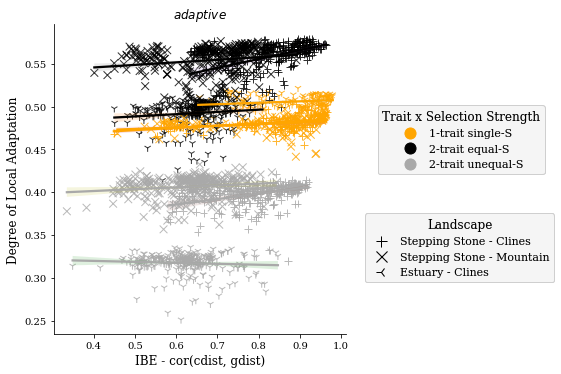

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/all_IBE_vs_final_LA_by_trait-slevel_by_landscape.pdf


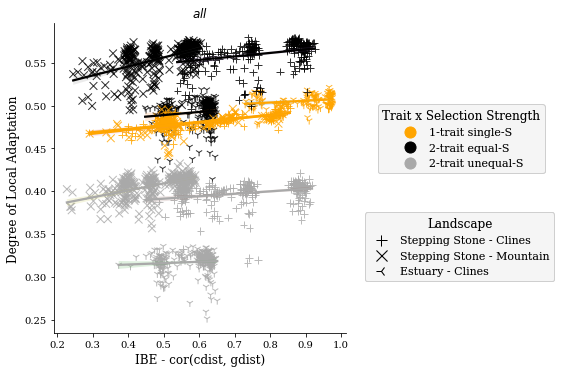

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/neutral_IBE_vs_final_LA_by_trait-slevel_by_landscape.pdf


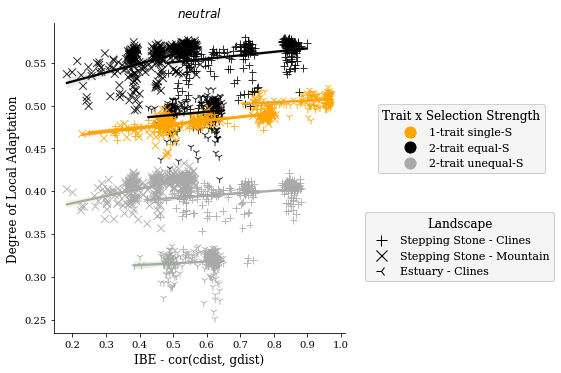

In [27]:
ls_dict = dict(zip(ibe_anno['landscape_slevel'], ibe_anno.landscape))

for marker_set in mvp.hue_order['marker_set']:
    g = sns.lmplot(
        data=ibe_anno,
        x=marker_set,
        y='final_LA',
        hue='landscape_slevel',
        hue_order=['Est-Clines_1-trait',
                   'Est-Clines_equal-S',
                   'Est-Clines_unequal-S',
                   'SS-Clines_1-trait',
                   'SS-Clines_equal-S',
                   'SS-Clines_unequal-S',
                   'SS-Mtn_1-trait',
                   'SS-Mtn_equal-S',
                   'SS-Mtn_unequal-S'],
#         palette=color_map,
#         palette=mvp.boxplot_kwargs['palette'],
        legend=False
    )

    change_markers(g, hue='landscape_slevel', marker_map=ls_dict, color_map=mvp.boxplot_kwargs['palette'])

    legend = mvp.add_legend(g.figure, color_by='landscape', use_markers=True, markeredgecolor='k',
                            loc='center left', bbox_to_anchor=(1, 0.35))

    mvp.factor_names['landscape_slevel'] = 'Trait x Selection Strength'
    mvp.hue_order['landscape_slevel'] = ['1-trait single-S', '2-trait equal-S', '2-trait unequal-S']

    for k, v in {'1-trait single-S': 'orange',
                 '2-trait equal-S': 'k',
                 '2-trait unequal-S': 'darkgray'}.items():

        mvp.boxplot_kwargs['palette'].update({k : v})
        mvp.factor_names.update({k : k})

    legend2 = mvp.add_legend(g.figure, color_by='landscape_slevel', loc='center left', bbox_to_anchor=(1.035, 0.65))

    g.ax.set_ylabel('Degree of Local Adaptation', fontsize=12)
    g.ax.set_xlabel('IBE - cor(cdist, gdist)', fontsize=12)
    g.ax.set_title(f'$\it{marker_set}$')

    save_pdf(f'{figdir}/{marker_set}_IBE_vs_final_LA_by_trait-slevel_by_landscape.pdf')

    plt.show()

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/adaptive_program_ibe-la-performance_heatmaps.pdf


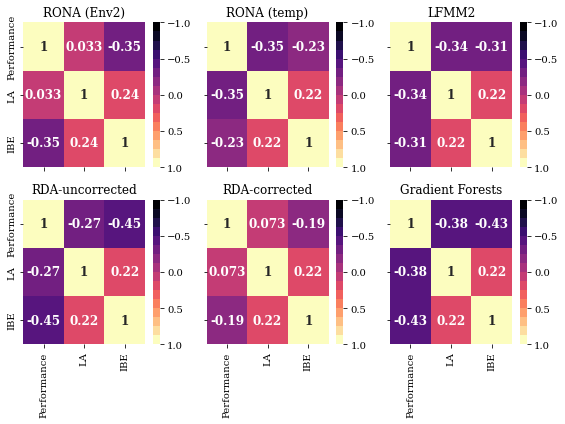

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/all_program_ibe-la-performance_heatmaps.pdf


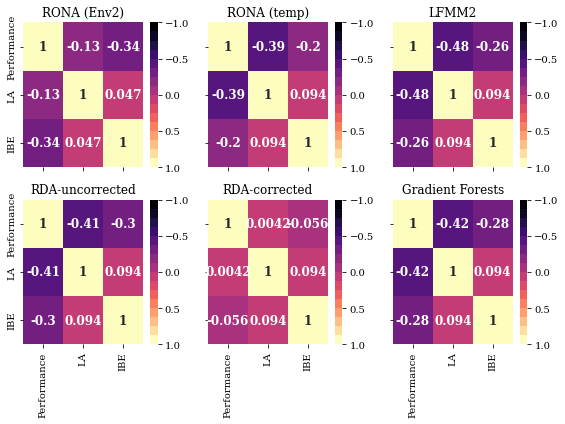

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/neutral_program_ibe-la-performance_heatmaps.pdf


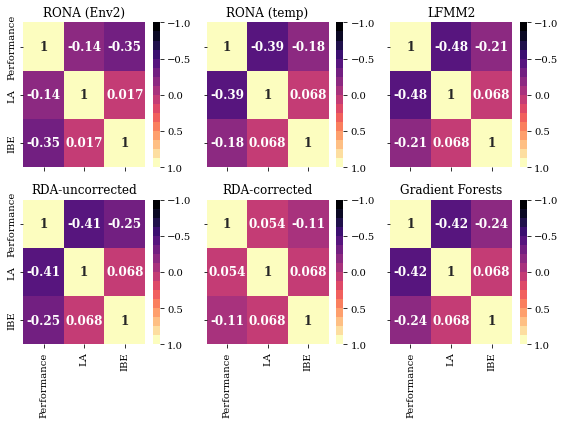

In [32]:
for marker_set in mvp.hue_order['marker_set']:
    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(8, 6))
    for i, program in enumerate(mvp.hue_order['program']):
        df = marker_data[marker_set][program].copy().to_frame()
        df.columns = ['Performance']
        
        df['LA'] = df.index.map(summary.final_LA)

        for param in ['landscape', 'slevel']:
            df[param] = df.index.map(params[param])

        df['IBE'] = df.index.map(corr_df.loc[marker_set])


        # create a heatmap with absolute correlation so I can compare final_LA to markerset IBE
        g = sns.heatmap(df.corr(method='kendall'), cmap=plt.cm.get_cmap("magma", lut=16), vmin=-1, vmax=1,
                        annot=True, annot_kws={'fontsize' : 12, 'weight' : 'bold'}, ax=axes.flat[i])

        g.axes.set_title(f'{mvp.factor_names[program]}')
        

        g.collections[0].colorbar.ax.invert_yaxis()

    plt.tight_layout()
    save_pdf(f'{figdir}/{marker_set}_program_ibe-la-performance_heatmaps.pdf')
    plt.show()


In [45]:
def scatter_perf_ibe(hue=None):
    for marker_set in mvp.hue_order['marker_set']:
        for program in mvp.hue_order['program']:
            scores = marker_data[marker_set][program].copy()

            interseeds = list(
                set(corr_df.columns).intersection(scores.index)
            )  # for RONA_sal

            # create df for seaborn
            sns_df = pd.merge(corr_df.loc[marker_set, interseeds],
                              scores.loc[interseeds],
                              left_index=True,
                              right_index=True)

            sns_df['landscape'] = sns_df.index.map(params.landscape)
            sns_df['slevel'] = sns_df.index.map(params.slevel)
            sns_df['landscape_slevel'] = sns_df.landscape + '_' + sns_df.slevel.fillna('1-trait')
            sns_df['final_LA_bin'] = sns_df.index.map(summary['final_LA_bin'])

            # calc relationship
            rel = round(corr_df.loc[marker_set, interseeds].corr(scores.loc[interseeds]), 2)

            g = sns.lmplot(data=sns_df,
                           x=marker_set,
                           y='score',
                           hue=hue,
    #                        hue_order=mvp.hue_order[hue],
                           palette=mvp.boxplot_kwargs['palette'],
                           legend=False
                          )

            g.axes[0][0].invert_yaxis()
            g.axes[0][0].set_title(f'{mvp.factor_names[program]} $\it{marker_set}$')
            g.axes[0][0].set_xlabel('IBE - cor(cdist, gdist)', fontsize=12)
            g.axes[0][0].set_ylabel("Median Performance (Kendall's $\\tau$)", fontsize=12)

            if hue == 'landscape_slevel':
                mvp.add_legend(g.figure, color_by='slevel_plus1', loc='center left', bbox_to_anchor=(1.03, 0.65))
                mvp.add_legend(g.figure, color_by='landscape', loc='center left', bbox_to_anchor=(1, 0.45),
                               use_markers=True, markeredgecolor='k')
            else:
                mvp.add_legend(g.figure, color_by=hue, loc='center left', bbox_to_anchor=(1, 0.66))

            save_pdf(f'{figdir}/{program}_{marker_set}_IBE_vs_median_performance_by_{hue}.pdf')

            plt.show()
    pass

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


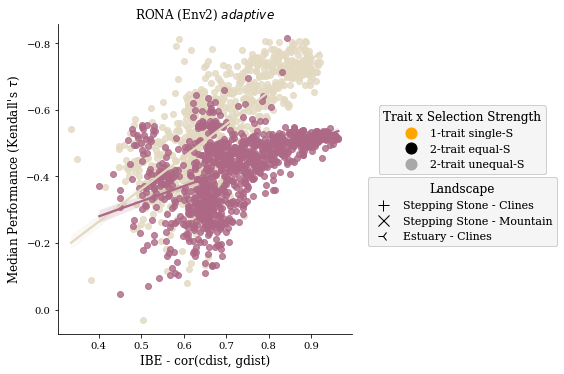

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


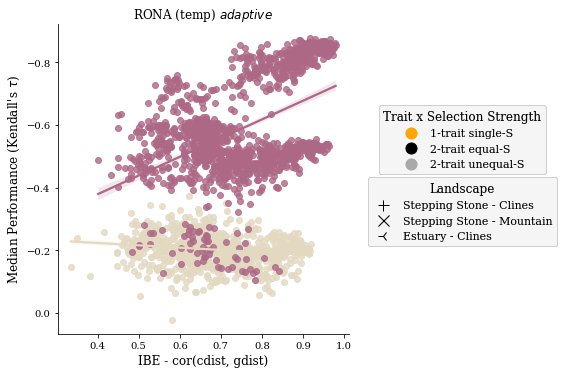

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


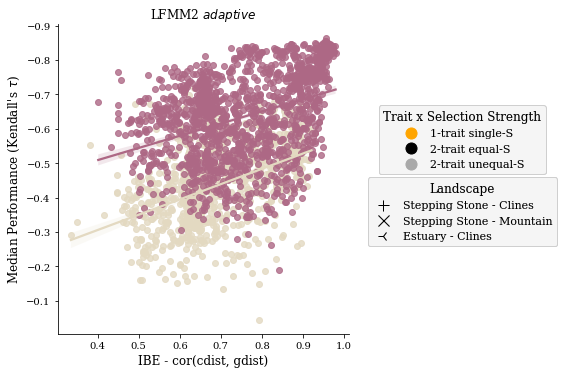

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


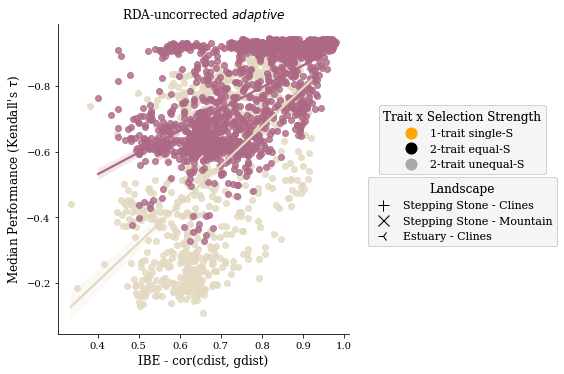

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


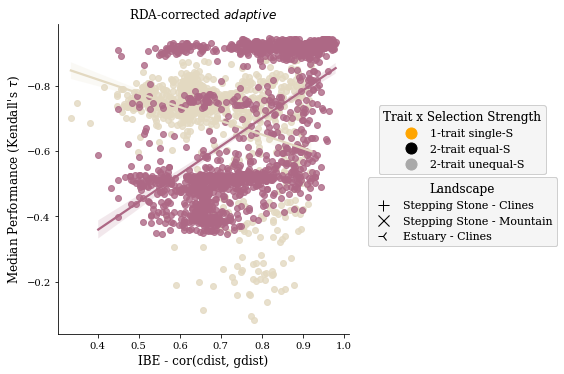

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_adaptive_IBE_vs_median_performance_by_final_LA_bin.pdf


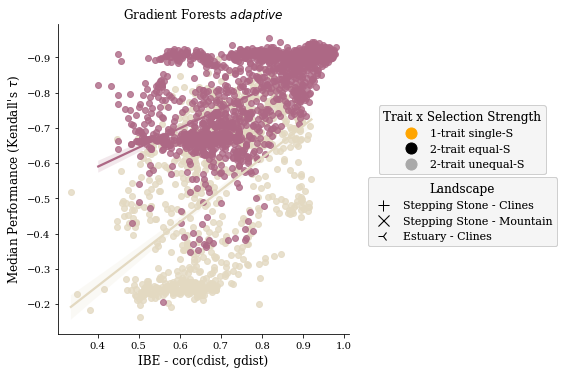

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_all_IBE_vs_median_performance_by_final_LA_bin.pdf


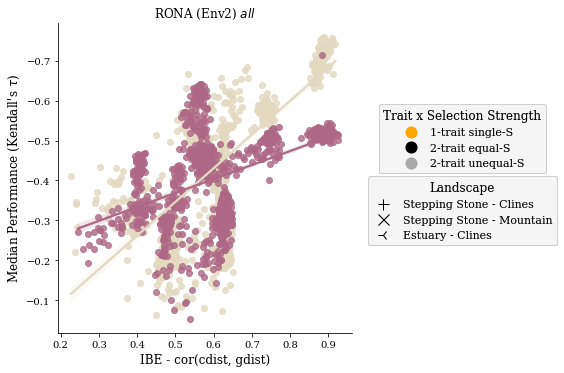

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_all_IBE_vs_median_performance_by_final_LA_bin.pdf


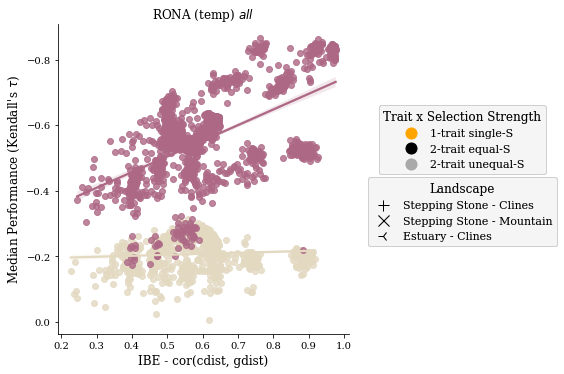

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_all_IBE_vs_median_performance_by_final_LA_bin.pdf


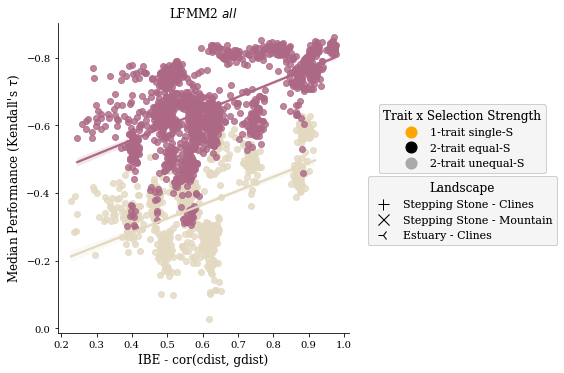

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_all_IBE_vs_median_performance_by_final_LA_bin.pdf


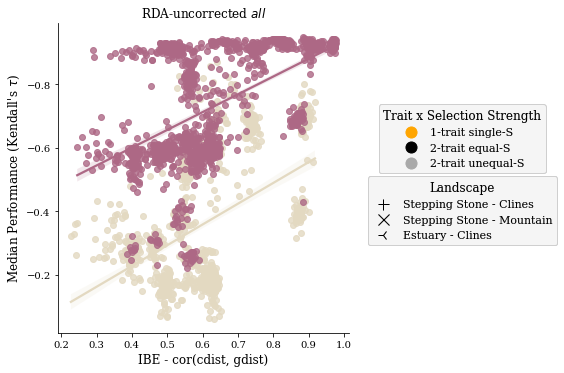

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_all_IBE_vs_median_performance_by_final_LA_bin.pdf


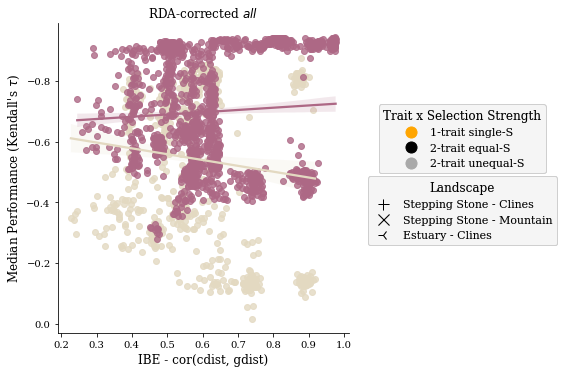

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_all_IBE_vs_median_performance_by_final_LA_bin.pdf


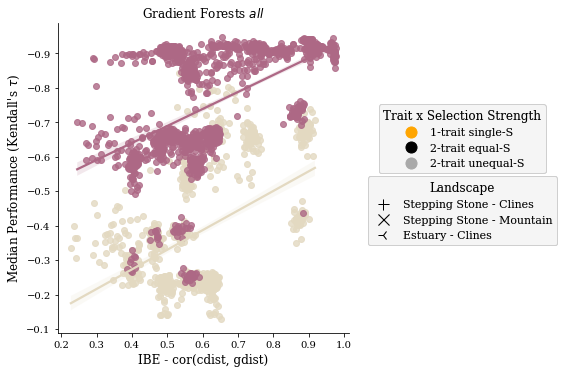

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


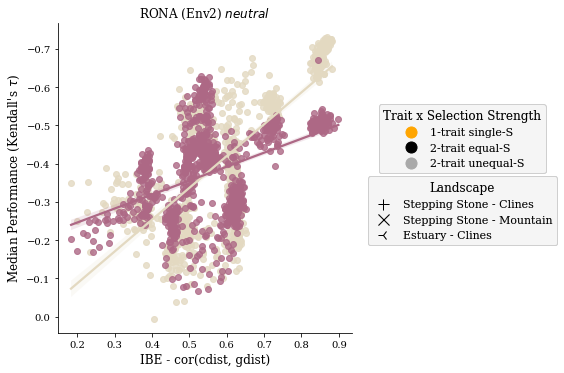

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


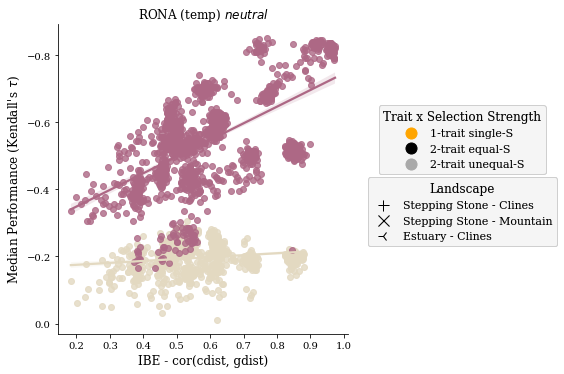

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


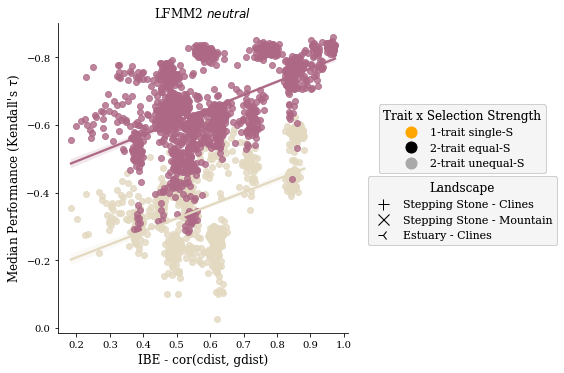

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


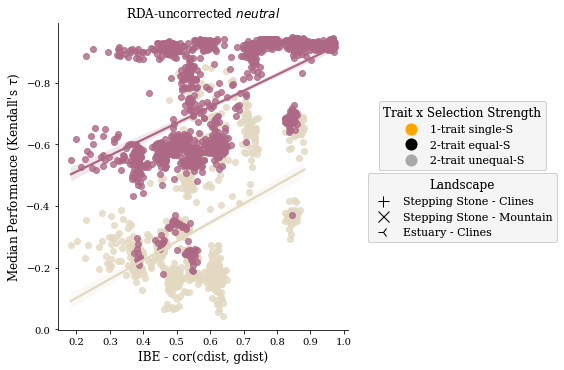

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


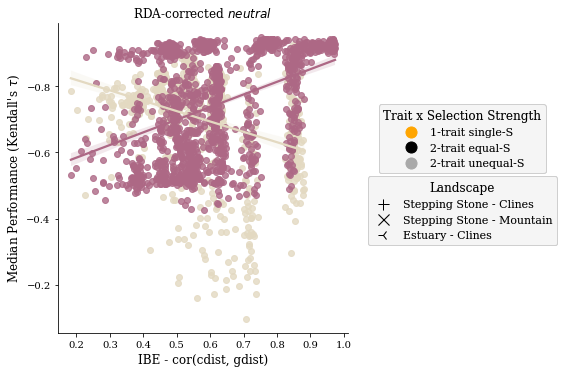

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_neutral_IBE_vs_median_performance_by_final_LA_bin.pdf


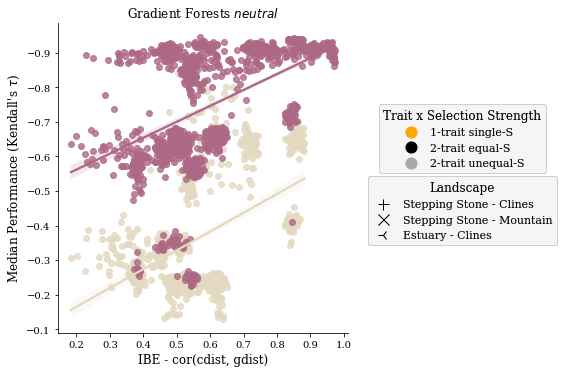

In [46]:
scatter_perf_ibe(hue='final_LA_bin')

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


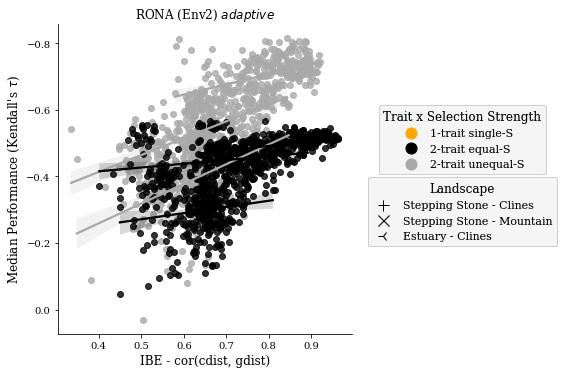

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


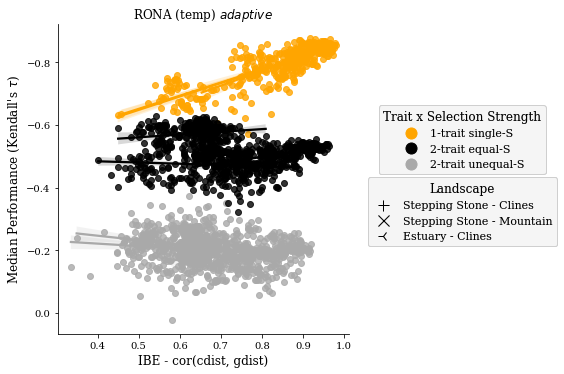

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


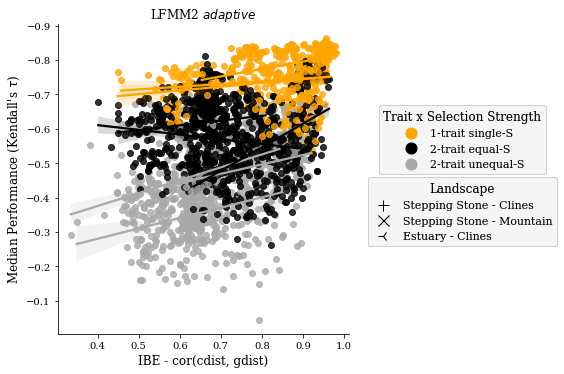

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


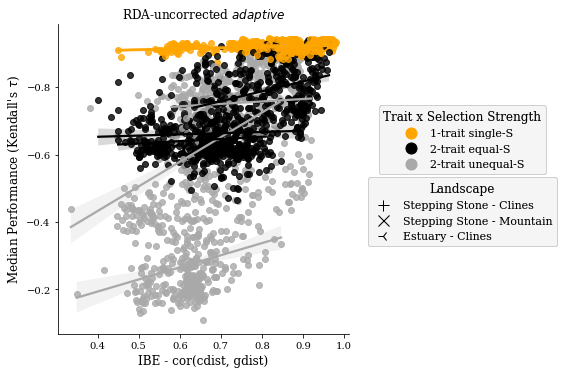

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


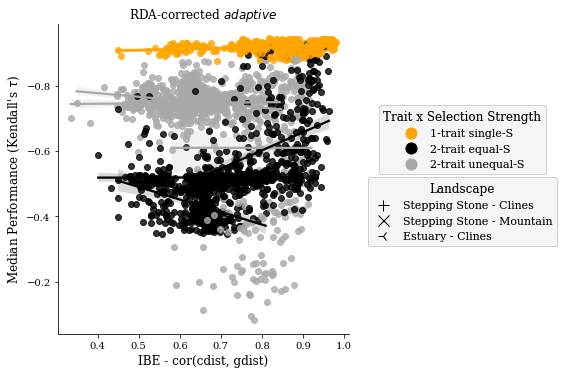

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_adaptive_IBE_vs_median_performance_by_landscape_slevel.pdf


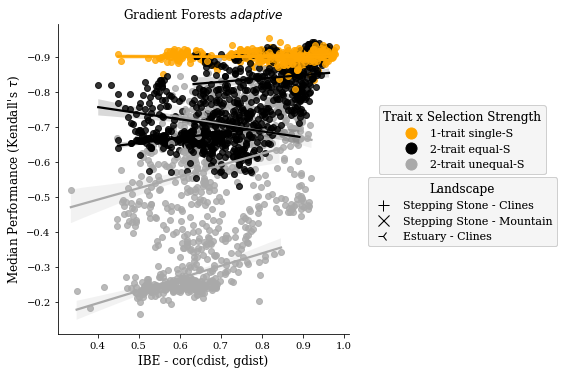

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_all_IBE_vs_median_performance_by_landscape_slevel.pdf


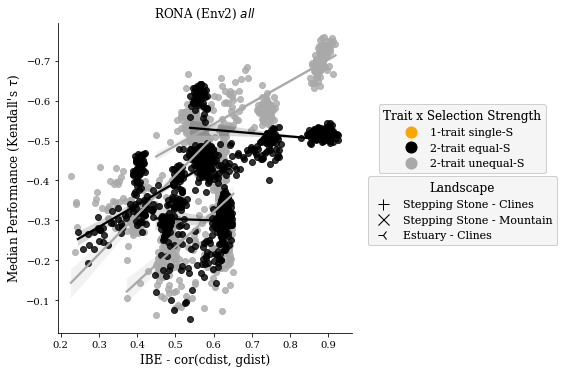

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_all_IBE_vs_median_performance_by_landscape_slevel.pdf


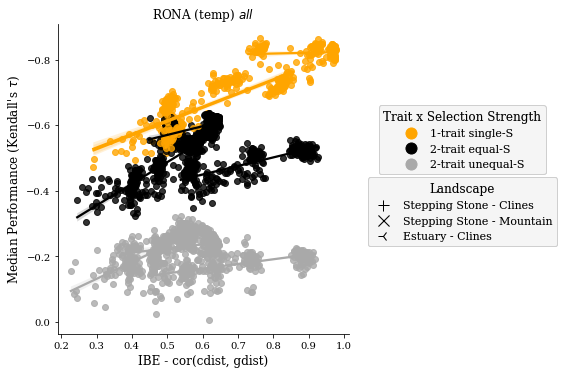

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_all_IBE_vs_median_performance_by_landscape_slevel.pdf


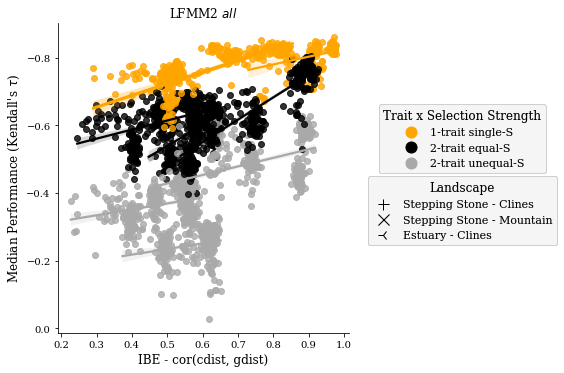

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_all_IBE_vs_median_performance_by_landscape_slevel.pdf


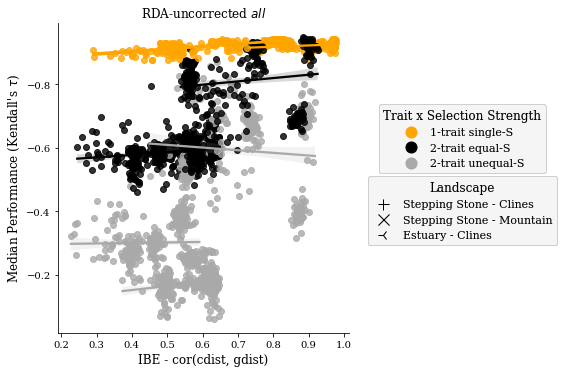

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_all_IBE_vs_median_performance_by_landscape_slevel.pdf


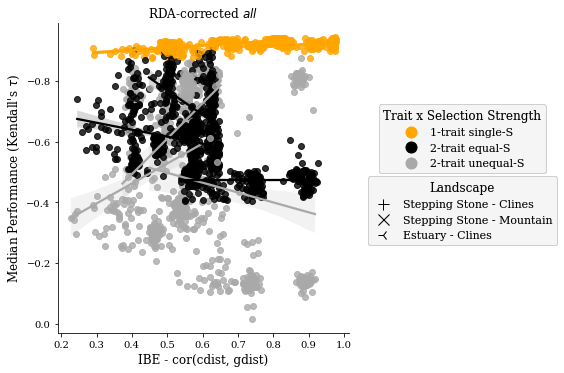

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_all_IBE_vs_median_performance_by_landscape_slevel.pdf


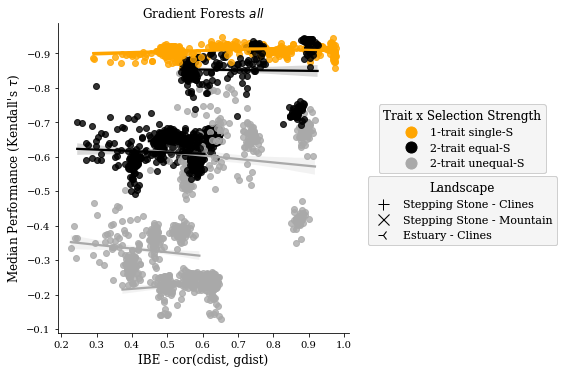

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-sal_opt_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


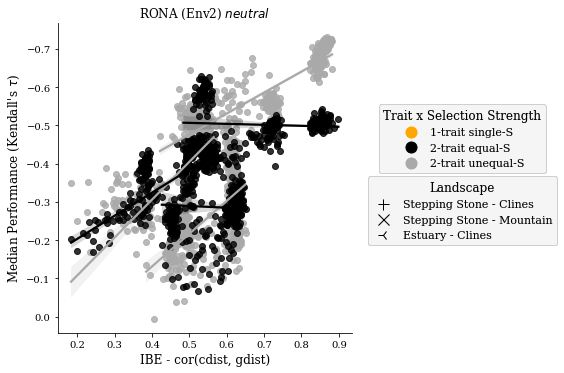

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/RONA-temp_opt_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


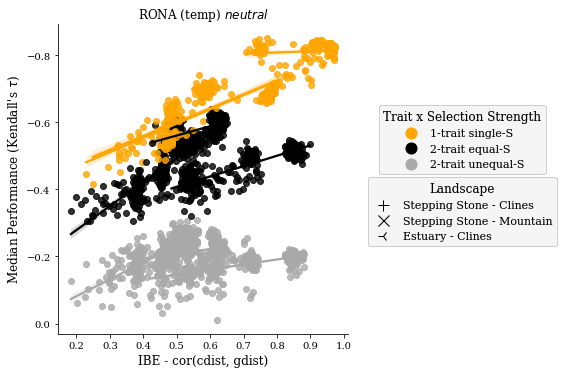

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/lfmm2_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


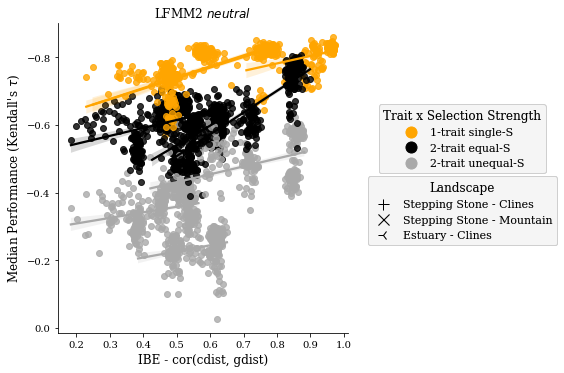

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-nocorr_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


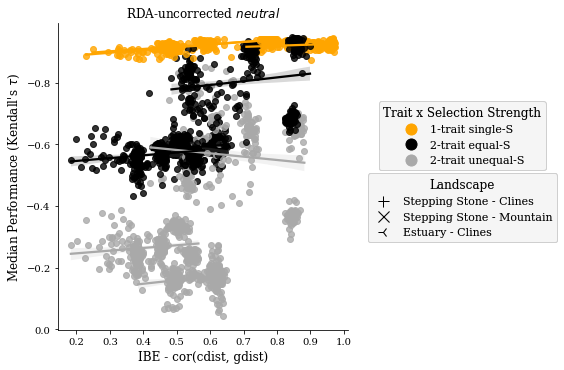

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/rda-structcorr_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


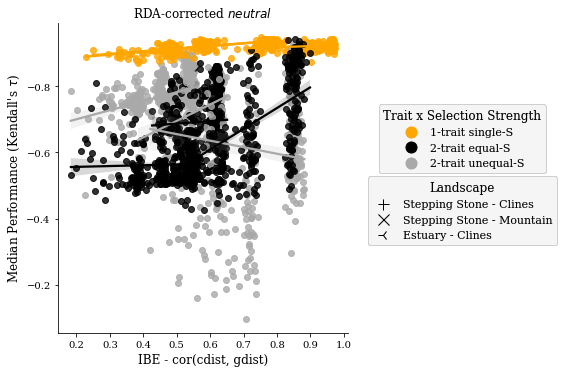

Saved to:  /home/b.lind/offsets/run_20220919/summaries/02_main_questions/10_ibe_vs_performance/GF_neutral_IBE_vs_median_performance_by_landscape_slevel.pdf


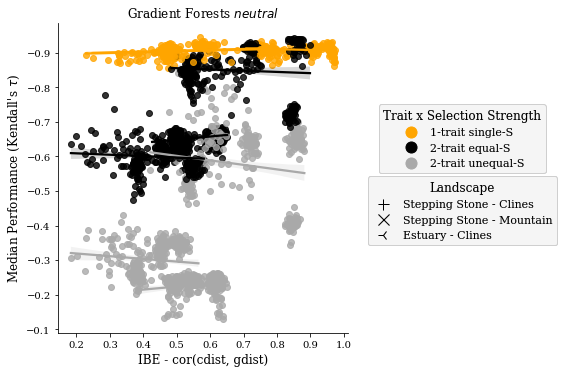

In [47]:
scatter_perf_ibe(hue='landscape_slevel')

In [30]:
formatclock(dt.now() - t0)

'0-00:01:46'

# keep!

determining seffs for fst stuff

In [1]:
from pythonimports import *

import MVP_summary_functions as mvp

lview, dview = get_client(cluster_id='1692623605-0gz4', profile='lotterhos')

36 36


In [25]:
all_seffs = {}
big_seffs = {}
for repdir in mvp.repdirs:
    fst_dir = f'{repdir}/fst/shfiles'
    
    if op.exists(fst_dir) is False:
        print(ColorText(f'NOPE : {fst_dir}!!!!!!!!!!').bold().fail())
        continue
        
    outs = fs(fst_dir, endswith='.out', exclude='watcher')
    
    seffs = Seffs.parallel(lview, outs=outs).most_recent()
    
    print(f'\n{repdir}')
    print(seffs.states.counter())
    
    all_seffs[repdir] = seffs
    big_seffs.update(seffs)
    
    pkl = f'{fst_dir}/seffs.pkl'
    pkldump(seffs, pkl)
    print(pkl)


Watching 450 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 450/450 [00:03<00:00, 118.91it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=450 luni=225
  warnings.warn(text)



/work/lotterhos/MVP-Offsets/run_20220919_0-225
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_0-225/fst/shfiles/seffs.pkl

Watching 450 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 450/450 [00:03<00:00, 120.90it/s]



/work/lotterhos/MVP-Offsets/run_20220919_225-450
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_225-450/fst/shfiles/seffs.pkl

Watching 399 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 399/399 [00:03<00:00, 125.47it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=399 luni=225
  warnings.warn(text)



/work/lotterhos/MVP-Offsets/run_20220919_450-675
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_450-675/fst/shfiles/seffs.pkl

Watching 257 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 257/257 [00:01<00:00, 135.39it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=257 luni=225
  warnings.warn(text)



/work/lotterhos/MVP-Offsets/run_20220919_675-900
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_675-900/fst/shfiles/seffs.pkl

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 136.15it/s]



/work/lotterhos/MVP-Offsets/run_20220919_900-1125
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_900-1125/fst/shfiles/seffs.pkl

Watching 336 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 336/336 [00:02<00:00, 128.84it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=336 luni=225
  warnings.warn(text)



/work/lotterhos/MVP-Offsets/run_20220919_1125-1350
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_1125-1350/fst/shfiles/seffs.pkl

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 122.72it/s]



/work/lotterhos/MVP-Offsets/run_20220919_1350-1575
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_1350-1575/fst/shfiles/seffs.pkl

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 136.62it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=226 luni=225
  warnings.warn(text)



/work/lotterhos/MVP-Offsets/run_20220919_1575-1800
Counter({'State: COMPLETED (exit code 0)': 225})
/work/lotterhos/MVP-Offsets/run_20220919_1575-1800/fst/shfiles/seffs.pkl

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 129.36it/s]



/work/lotterhos/MVP-Offsets/run_20220919_1800-2025
Counter({'State: COMPLETED (exit code 0)': 224, 'State: FAILED (exit code 1)': 1})
/work/lotterhos/MVP-Offsets/run_20220919_1800-2025/fst/shfiles/seffs.pkl

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 114.09it/s]


/work/lotterhos/MVP-Offsets/run_20220919_2025-2250
Counter({'State: COMPLETED (exit code 0)': 224, 'State: FAILED (exit code 1)': 1})
/work/lotterhos/MVP-Offsets/run_20220919_2025-2250/fst/shfiles/seffs.pkl


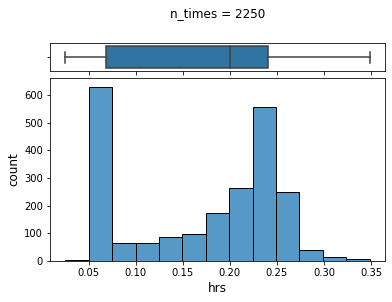

In [6]:
Seffs(seffs=big_seffs).plot_times()

In [7]:
Seffs(seffs=big_seffs).times.mean()

0.16969604938271624

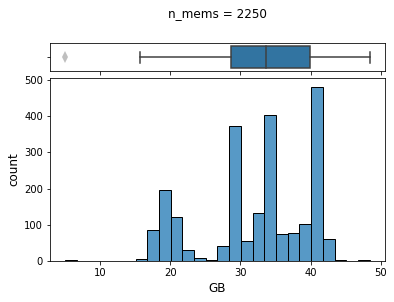

In [10]:
Seffs(seffs=big_seffs).plot_mems(units='GB')

In [12]:
Seffs(seffs=big_seffs).mem_reqs.mean()

4003.8399999998946

In [31]:
needed = []
for repdir, seffs in all_seffs.items():
    shfiles = fs(f'{repdir}/fst/shfiles', endswith='.sh', exclude='watcher')
    assert len(shfiles) == 225
    
    rep_needed = list(
        set(shfiles) - set(seffs.completed().shfiles)
    )
    
    print(op.basename(repdir).split("_")[-1], len(rep_needed))
    
    needed.extend(rep_needed)
    
len(needed)

0-225 0
225-450 0
450-675 0
675-900 0
900-1125 0
1125-1350 0
1350-1575 0
1575-1800 0
1800-2025 1
2025-2250 1


2

In [33]:
Squeue(p='short', states='PD').update(to_partition='long', num_jobs=0.5)

update: 100%|███████████████| 1/1 [00:00<00:00, 10.80it/s]
